In [1]:
import sys
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import torch
import torch.nn as nn
import torch.nn.functional as F
from primitives import gaussian_blur, get_box_atm_indices, Residue
from scipy.ndimage import gaussian_filter
from scipy.signal.windows import gaussian
from matplotlib.pyplot import figure
# from pyuul import VolumeMaker # the main PyUUL module
from pyuul import utils
from myvolmaker import Voxels
from proteinshake.tasks import EnzymeClassTask, ProteinProteinInterfaceTask
from proteinshake.datasets import Dataset
from torch.utils.data import DataLoader

# Use proteins with Enzyme Class annotations
# Convert them to voxels with a voxelsize of 10 Angstrom
# Load into PyTorch data structures
# task = ProteinProteinInterfaceTask().to_voxel(voxelsize=10).torch()
# task = ProteinProteinInterfaceTask()
# task.to_voxel(voxelsize=10).torch()
# train, test = DataLoader(task.train), DataLoader(task.test)

casa = Path("/home/pbarletta/labo/23/paco")
dlp = Path("/home/pbarletta/labo/22/locuaz/rebin/dlpacker")
weights_path = Path(dlp, "DLPacker_weights.h5")
lib_path = Path(dlp, "library.npz")
charges_path = Path(dlp, "charges.rtp")

In [2]:
input_pdb_fn = Path(casa, "c.pdb")
coords, atname = utils.parsePDB(input_pdb_fn)
atoms_channel = utils.atomlistToChannels(atname)
radius = utils.atomlistToRadius(atname)
resolution = 1

volmaker = Voxels(device="cpu",sparse=False)
voxelized_volume = volmaker(coords, radius, atoms_channel,
                            resolution=resolution, cubes_around_atoms_dim=5,
                            function="gaussian")
voxels = voxelized_volume.sum(1)[:, None, :, :]
sp_voxels = voxels.to_sparse()
sp_voxels = sp_voxels[0, 0].coalesce()
volmaker.boxsize, volmaker.lato

((11, 13, 14), 11)

In [8]:
volmaker.cubes_coords[:, 0]

tensor([ 1,  1,  1,  ..., 11, 11, 11], dtype=torch.int16)

In [5]:
cubes_coords

NameError: name 'cubes_coords' is not defined

In [125]:
cubes_around_atoms_dim = 5
mincoords = torch.min(coords, dim=1)[0] / resolution
translation = (mincoords - (cubes_around_atoms_dim)).unsqueeze(1)

In [154]:
coords_scaled = coords - translation
coords_scaled = coords_scaled[:, :, None, None, None, :]

discrete_coordinates = torch.trunc(coords_scaled.data).to(torch.int)
discrete_coordinates = discrete_coordinates[:, :, None, None, None, :]

standard_cube = volmaker.standard_cube

In [155]:
distmat_standard_cube = torch.norm(
            coords_scaled
            - ((discrete_coordinates + standard_cube + 1) + 0.5 * resolution),
            dim=-1,
        ).to(coords_scaled.dtype)

In [157]:
discrete_coordinates.shape

torch.Size([1, 10, 1, 1, 1, 1, 1, 1, 3])

In [159]:
standard_cube.shape

torch.Size([11, 11, 11, 3])

In [162]:
a = discrete_coordinates + standard_cube + .5
a

tensor([[[[[[[[[13.5000,  2.5000,  6.5000],
               [13.5000,  2.5000,  7.5000],
               [13.5000,  2.5000,  8.5000],
               ...,
               [13.5000,  2.5000, 14.5000],
               [13.5000,  2.5000, 15.5000],
               [13.5000,  2.5000, 16.5000]],

              [[13.5000,  3.5000,  6.5000],
               [13.5000,  3.5000,  7.5000],
               [13.5000,  3.5000,  8.5000],
               ...,
               [13.5000,  3.5000, 14.5000],
               [13.5000,  3.5000, 15.5000],
               [13.5000,  3.5000, 16.5000]],

              [[13.5000,  4.5000,  6.5000],
               [13.5000,  4.5000,  7.5000],
               [13.5000,  4.5000,  8.5000],
               ...,
               [13.5000,  4.5000, 14.5000],
               [13.5000,  4.5000, 15.5000],
               [13.5000,  4.5000, 16.5000]],

              ...,

              [[13.5000, 10.5000,  6.5000],
               [13.5000, 10.5000,  7.5000],
               [13.5000, 10.5000, 

In [167]:
b = (coords_scaled - a).to(torch.float32)
b

tensor([[[[[[[[[ 5.3400e+00,  4.5500e+00,  4.6300e+00],
               [ 5.3400e+00,  4.5500e+00,  3.6300e+00],
               [ 5.3400e+00,  4.5500e+00,  2.6300e+00],
               ...,
               [ 5.3400e+00,  4.5500e+00, -3.3700e+00],
               [ 5.3400e+00,  4.5500e+00, -4.3700e+00],
               [ 5.3400e+00,  4.5500e+00, -5.3700e+00]],

              [[ 5.3400e+00,  3.5500e+00,  4.6300e+00],
               [ 5.3400e+00,  3.5500e+00,  3.6300e+00],
               [ 5.3400e+00,  3.5500e+00,  2.6300e+00],
               ...,
               [ 5.3400e+00,  3.5500e+00, -3.3700e+00],
               [ 5.3400e+00,  3.5500e+00, -4.3700e+00],
               [ 5.3400e+00,  3.5500e+00, -5.3700e+00]],

              [[ 5.3400e+00,  2.5500e+00,  4.6300e+00],
               [ 5.3400e+00,  2.5500e+00,  3.6300e+00],
               [ 5.3400e+00,  2.5500e+00,  2.6300e+00],
               ...,
               [ 5.3400e+00,  2.5500e+00, -3.3700e+00],
               [ 5.3400e+00,  2.5500e+00

In [179]:
exp_mask = torch.zeros((10, 11, 11, 11)).to(torch.bool)
exp_mask.shape

torch.Size([10, 11, 11, 11])

In [202]:
padding_mask = torch.ones((1, 10)).to(torch.bool)
cubes_coords = discrete_coordinates[padding_mask] + standard_cube.squeeze(0) + 1
cubes_coords.shape

torch.Size([10, 1, 1, 1, 11, 11, 11, 3])

In [214]:
standard_cube[5, 5, 5]

tensor([0, 0, 0], dtype=torch.int16)

In [230]:
discrete_coordinates.squeeze()

tensor([[18,  7, 11],
        [19,  5,  7],
        [20,  7,  5],
        [22,  8,  7],
        [20, 11,  8],
        [17, 12, 10],
        [14, 10, 11],
        [10, 10, 11],
        [ 8, 12, 13],
        [ 5, 11, 11]], dtype=torch.int32)

In [231]:
cubes_coords.shape

torch.Size([10, 11, 11, 11, 3])

In [242]:
cubes_around_atoms_dim = 5
ncubes = 2 * cubes_around_atoms_dim + 1
center = ncubes // 2
cubes_coords = cubes_coords.squeeze(1)
cubes_coords[0][center, center, center]

tensor([19,  8, 12], dtype=torch.int32)

In [247]:
discrete_coordinates[padding_mask].squeeze()

tensor([[18,  7, 11],
        [19,  5,  7],
        [20,  7,  5],
        [22,  8,  7],
        [20, 11,  8],
        [17, 12, 10],
        [14, 10, 11],
        [10, 10, 11],
        [ 8, 12, 13],
        [ 5, 11, 11]], dtype=torch.int32)

In [271]:
batch = coords_scaled.shape[0]
natoms = coords_scaled.shape[1]
boxsize = volmaker.boxsize
featureVectorSize = volmaker.featureVectorSize

batch_list = (
            torch.arange(batch)
            .unsqueeze(1)
            .unsqueeze(1)
            .unsqueeze(1)
            .unsqueeze(1)
            .expand(batch, natoms, volmaker.lato, volmaker.lato, volmaker.lato)
        )
atNameHashing = torch.zeros((10, 11, 11, 11))

index = (
    batch_list[padding_mask][~exp_mask].view(-1).long(),
    cubes_coords[:, 0].long(),
    cubes_coords[:, 1].long(),
    cubes_coords[:, 2].long(),
    atNameHashing[~exp_mask],
)

In [296]:
cubes_coords.shape

torch.Size([10, 11, 11, 11, 3])

In [292]:
cubes_coords[0, 0]

tensor([[[14,  3,  7],
         [14,  3,  8],
         [14,  3,  9],
         [14,  3, 10],
         [14,  3, 11],
         [14,  3, 12],
         [14,  3, 13],
         [14,  3, 14],
         [14,  3, 15],
         [14,  3, 16],
         [14,  3, 17]],

        [[14,  4,  7],
         [14,  4,  8],
         [14,  4,  9],
         [14,  4, 10],
         [14,  4, 11],
         [14,  4, 12],
         [14,  4, 13],
         [14,  4, 14],
         [14,  4, 15],
         [14,  4, 16],
         [14,  4, 17]],

        [[14,  5,  7],
         [14,  5,  8],
         [14,  5,  9],
         [14,  5, 10],
         [14,  5, 11],
         [14,  5, 12],
         [14,  5, 13],
         [14,  5, 14],
         [14,  5, 15],
         [14,  5, 16],
         [14,  5, 17]],

        [[14,  6,  7],
         [14,  6,  8],
         [14,  6,  9],
         [14,  6, 10],
         [14,  6, 11],
         [14,  6, 12],
         [14,  6, 13],
         [14,  6, 14],
         [14,  6, 15],
         [14,  6, 16],
     

In [293]:
cubes_coords[0, 1]

tensor([[[15,  3,  7],
         [15,  3,  8],
         [15,  3,  9],
         [15,  3, 10],
         [15,  3, 11],
         [15,  3, 12],
         [15,  3, 13],
         [15,  3, 14],
         [15,  3, 15],
         [15,  3, 16],
         [15,  3, 17]],

        [[15,  4,  7],
         [15,  4,  8],
         [15,  4,  9],
         [15,  4, 10],
         [15,  4, 11],
         [15,  4, 12],
         [15,  4, 13],
         [15,  4, 14],
         [15,  4, 15],
         [15,  4, 16],
         [15,  4, 17]],

        [[15,  5,  7],
         [15,  5,  8],
         [15,  5,  9],
         [15,  5, 10],
         [15,  5, 11],
         [15,  5, 12],
         [15,  5, 13],
         [15,  5, 14],
         [15,  5, 15],
         [15,  5, 16],
         [15,  5, 17]],

        [[15,  6,  7],
         [15,  6,  8],
         [15,  6,  9],
         [15,  6, 10],
         [15,  6, 11],
         [15,  6, 12],
         [15,  6, 13],
         [15,  6, 14],
         [15,  6, 15],
         [15,  6, 16],
     

In [294]:
cubes_coords[0, 2]

tensor([[[16,  3,  7],
         [16,  3,  8],
         [16,  3,  9],
         [16,  3, 10],
         [16,  3, 11],
         [16,  3, 12],
         [16,  3, 13],
         [16,  3, 14],
         [16,  3, 15],
         [16,  3, 16],
         [16,  3, 17]],

        [[16,  4,  7],
         [16,  4,  8],
         [16,  4,  9],
         [16,  4, 10],
         [16,  4, 11],
         [16,  4, 12],
         [16,  4, 13],
         [16,  4, 14],
         [16,  4, 15],
         [16,  4, 16],
         [16,  4, 17]],

        [[16,  5,  7],
         [16,  5,  8],
         [16,  5,  9],
         [16,  5, 10],
         [16,  5, 11],
         [16,  5, 12],
         [16,  5, 13],
         [16,  5, 14],
         [16,  5, 15],
         [16,  5, 16],
         [16,  5, 17]],

        [[16,  6,  7],
         [16,  6,  8],
         [16,  6,  9],
         [16,  6, 10],
         [16,  6, 11],
         [16,  6, 12],
         [16,  6, 13],
         [16,  6, 14],
         [16,  6, 15],
         [16,  6, 16],
     

In [295]:
cubes_coords[0, 3]

tensor([[[17,  3,  7],
         [17,  3,  8],
         [17,  3,  9],
         [17,  3, 10],
         [17,  3, 11],
         [17,  3, 12],
         [17,  3, 13],
         [17,  3, 14],
         [17,  3, 15],
         [17,  3, 16],
         [17,  3, 17]],

        [[17,  4,  7],
         [17,  4,  8],
         [17,  4,  9],
         [17,  4, 10],
         [17,  4, 11],
         [17,  4, 12],
         [17,  4, 13],
         [17,  4, 14],
         [17,  4, 15],
         [17,  4, 16],
         [17,  4, 17]],

        [[17,  5,  7],
         [17,  5,  8],
         [17,  5,  9],
         [17,  5, 10],
         [17,  5, 11],
         [17,  5, 12],
         [17,  5, 13],
         [17,  5, 14],
         [17,  5, 15],
         [17,  5, 16],
         [17,  5, 17]],

        [[17,  6,  7],
         [17,  6,  8],
         [17,  6,  9],
         [17,  6, 10],
         [17,  6, 11],
         [17,  6, 12],
         [17,  6, 13],
         [17,  6, 14],
         [17,  6, 15],
         [17,  6, 16],
     

In [269]:
cubes_coords[:, 2].shape

torch.Size([10, 11, 11, 3])

In [274]:
volume = torch.zeros(
    batch,
    boxsize[0] + 1,
    boxsize[1] + 1,
    boxsize[2] + 1,
    featureVectorSize,
    dtype=torch.float,
)

In [275]:
volume.shape

torch.Size([1, 29, 19, 20, 1])

In [168]:
cubes_coords

torch.Size([1, 10, 1, 1, 10, 11, 11, 11, 3])

In [5]:
coords_scaled = torch.tensor([[[[[[18.8400,  7.0500, 11.1300]]]],
    [[[[19.3900,  5.0000,  7.7800]]]],
    [[[[20.1900,  7.7100,  5.0000]]]],
    [[[[22.3900,  8.3000,  7.2700]]]],
    [[[[20.7200, 11.6300,  8.2100]]]],
    [[[[17.4000, 12.6400, 10.1600]]]],
    [[[[14.7100, 10.3800, 11.7100]]]],
    [[[[10.8400, 10.2500, 11.5200]]]],
    [[[[ 8.2800, 12.5600, 13.2600]]]],
    [[[[ 5.0000, 11.1100, 11.8000]]]]]])

discrete_coordinates = torch.tensor([[[[[[18,  7, 11]]]],
    [[[[19,  5,  7]]]],
    [[[[20,  7,  5]]]],
    [[[[22,  8,  7]]]],
    [[[[20, 11,  8]]]],
    [[[[17, 12, 10]]]],
    [[[[14, 10, 11]]]],
    [[[[10, 10, 11]]]],
    [[[[ 8, 12, 13]]]],
    [[[[ 5, 11, 11]]]]]], dtype=torch.uint8)
standard_cube = volmaker.standard_cube

In [6]:
coords_scaled.shape, discrete_coordinates.shape

(torch.Size([1, 10, 1, 1, 1, 3]), torch.Size([1, 10, 1, 1, 1, 3]))

In [7]:
a = discrete_coordinates + standard_cube
a.shape

torch.Size([1, 10, 11, 11, 11, 3])

In [8]:
standard_cube[0][0]

tensor([[-5, -5, -5],
        [-5, -5, -4],
        [-5, -5, -3],
        [-5, -5, -2],
        [-5, -5, -1],
        [-5, -5,  0],
        [-5, -5,  1],
        [-5, -5,  2],
        [-5, -5,  3],
        [-5, -5,  4],
        [-5, -5,  5]], dtype=torch.int16)

In [9]:
volmaker.distmat_standard_cube

tensor([[[[[ 6.6795,  6.1931,  5.8391,  ...,  7.1088,  7.7637,  8.4862],
           [ 6.2060,  5.6794,  5.2910,  ...,  6.6660,  7.3604,  8.1188],
           [ 5.8664,  5.3061,  4.8883,  ...,  6.3510,  7.0764,  7.8623],
           ...,
           [ 7.1983,  6.7494,  6.4261,  ...,  7.5984,  8.2143,  8.9003],
           [ 7.8559,  7.4468,  7.1551,  ...,  8.2241,  8.7963,  9.4401],
           [ 8.5799,  8.2070,  7.9432,  ...,  8.9182,  9.4485, 10.0506]],

          [[ 6.0774,  5.5385,  5.1396,  ...,  6.5464,  7.2522,  8.0209],
           [ 5.5529,  4.9573,  4.5072,  ...,  6.0626,  6.8187,  7.6312],
           [ 5.1706,  4.5249,  4.0268,  ...,  5.7145,  6.5111,  7.3577],
           ...,
           [ 6.6434,  6.1543,  5.7978,  ...,  7.0750,  7.7327,  8.4578],
           [ 7.3508,  6.9119,  6.5966,  ...,  7.7431,  8.3484,  9.0241],
           [ 8.1200,  7.7250,  7.4441,  ...,  8.4767,  9.0330,  9.6610]],

          [[ 5.5906,  4.9995,  4.5536,  ...,  6.0971,  6.8495,  7.6587],
           [ 5.

In [102]:
i = 0
at0 = volmaker.distmat_standard_cube[0, i]
np.unravel_index(torch.argmin(at0), at0.shape)

(4, 4, 4)

In [108]:
coords_scaled

tensor([[[[[[18.8400,  7.0500, 11.1300]]]],



         [[[[19.3900,  5.0000,  7.7800]]]],



         [[[[20.1900,  7.7100,  5.0000]]]],



         [[[[22.3900,  8.3000,  7.2700]]]],



         [[[[20.7200, 11.6300,  8.2100]]]],



         [[[[17.4000, 12.6400, 10.1600]]]],



         [[[[14.7100, 10.3800, 11.7100]]]],



         [[[[10.8400, 10.2500, 11.5200]]]],



         [[[[ 8.2800, 12.5600, 13.2600]]]],



         [[[[ 5.0000, 11.1100, 11.8000]]]]]])

In [107]:
volmaker.boxsize

(28, 18, 19)

In [106]:
voxels.shape

torch.Size([1, 1, 29, 19, 20])

In [82]:
a = torch.zeros(2, 3, 4)
a

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

In [83]:
v = torch.arange(1, 4, dtype=torch.float32)
v

tensor([1., 2., 3.])

In [22]:
np.unravel_index(torch.argmin(at0), at0.shape)

(4, 4, 4)

In [26]:
at0[3:6, 3:6, 3:6]

tensor([[[1.5796, 1.4950, 1.9937],
         [1.5476, 1.4612, 1.9685],
         [2.0724, 2.0087, 2.4031]],

        [[0.9028, 0.7450, 1.5149],
         [0.8456, 0.6745, 1.4816],
         [1.6171, 1.5346, 2.0236]],

        [[1.0654, 0.9354, 1.6171],
         [1.0173, 0.8803, 1.5859],
         [1.7132, 1.6355, 2.1012]]])

In [17]:
volmaker.distmat_standard_cube[0, 0].shape

torch.Size([11, 11, 11])

In [41]:
sp_voxels = voxels.to_sparse()

sp_voxels.indices()[2:, 2]

tensor([3, 4, 3])

In [11]:
sp_voxels.values().shape

torch.Size([512])

In [13]:
sp_voxels

tensor(indices=tensor([[ 0,  0,  0,  ...,  0,  0,  0],
                       [ 0,  0,  0,  ...,  0,  0,  0],
                       [ 3,  3,  3,  ..., 27, 27, 27],
                       [ 3,  3,  4,  ...,  4,  5,  5],
                       [ 4,  5,  3,  ..., 15, 14, 15]]),
       values=tensor([6.7881e-04, 6.7881e-04, 6.7881e-04, 1.1075e-01,
                      1.1075e-01, 6.7881e-04, 1.3816e-03, 1.3816e-03,
                      6.7881e-04, 1.1075e-01, 1.1075e-01, 6.7881e-04,
                      1.3816e-03, 1.3816e-03, 6.7881e-04, 6.7881e-04,
                      1.3816e-03, 1.3816e-03, 1.3816e-03, 1.3816e-03,
                      1.3816e-03, 1.3816e-03, 1.3816e-03, 1.3816e-03,
                      6.7881e-04, 1.1075e-01, 1.1075e-01, 6.7881e-04,
                      1.3816e-03, 1.3816e-03, 1.1075e-01, 9.9710e-01,
                      9.9710e-01, 1.1075e-01, 1.3816e-03, 7.9245e-01,
                      7.9245e-01, 1.3816e-03, 1.1075e-01, 9.9710e-01,
                      9

In [6]:
padding_mask = ~atoms_channel.eq(999.0)
cubes_around_atoms_dim = 5

In [7]:
import math
resolution = 1
mincoords = torch.min(coords[:, :, :], dim=1)[0]
mincoords = torch.trunc(mincoords / resolution)

box_size_x = (math.ceil(torch.max(coords[padding_mask][:,0])/resolution)-mincoords[:,0].min())+(2*cubes_around_atoms_dim+1)
box_size_y = (math.ceil(torch.max(coords[padding_mask][:,1])/resolution)-mincoords[:,1].min())+(2*cubes_around_atoms_dim+1)
box_size_z = (math.ceil(torch.max(coords[padding_mask][:,2])/resolution)-mincoords[:,2].min())+(2*cubes_around_atoms_dim+1)


In [20]:
torch.min(coords, dim = 1)[0]

tensor([[0., 0., 0.]])

In [24]:
torch.max(coords[padding_mask][:, 0]) / resolution

tensor(20.)

In [53]:
max_coords = torch.max(coords[padding_mask], dim=0)[0] / resolution
min_coords = torch.min(coords[:, :, :], dim=1)[0] / resolution
pad = 2 * cubes_around_atoms_dim + 1
max_coords - min_coords + pad

tensor([[31., 21., 21.]])

In [55]:
t = max_coords - min_coords + pad

In [76]:
t

tensor([[31., 21., 21.]])

(31, 21, 21)

In [59]:
type(volmaker.boxsize[0])

int

In [25]:
coords[padding_mask]

tensor([[ 0.,  0.,  0.],
        [ 0.,  0., 10.],
        [ 0., 10.,  0.],
        [ 0., 10., 10.],
        [10.,  0.,  0.],
        [10.,  0., 10.],
        [10., 10.,  0.],
        [10., 10., 10.],
        [20.,  0.,  0.],
        [20.,  0., 10.]])

In [33]:
torch.ceil(1.1)

TypeError: ceil(): argument 'input' (position 1) must be Tensor, not float

In [31]:
coords.shape

torch.Size([1, 10])

In [28]:
padding_mask.shape

torch.Size([1, 10])

In [27]:
coords.shape

torch.Size([1, 10, 3])

In [128]:
g = gaussian(3, std=.6)
g3d = g[None, :, None] @ g[:, None, None] @ g[None, None, :]
g3d /= np.sum(g3d)
g3d = torch.from_numpy(g3d[None, None, :, :].astype(np.float32))

xx = F.conv3d(voxels, g3d, padding=1)

In [144]:
voxels

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           

In [146]:
torch.save(voxels[0, 0, :, :, :], "t.pt")

TypeError: tuple indices must be integers or slices, not tuple

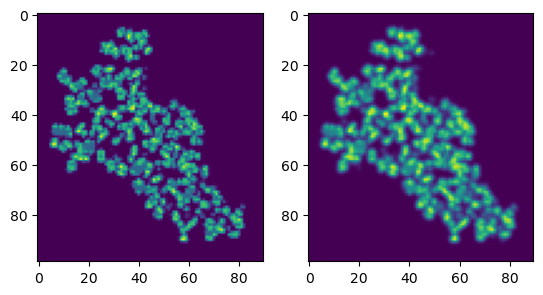

In [129]:
fig, ax = plt.subplots(1, 2)
l = 30
ax[0].imshow(voxels[0][0][l, :, :])
ax[1].imshow(xx[0][0][l, :, :])